# Algoritmo Genético para resolver un TSP

Probando con 100 puntos. Cuanto nos tardaríamos?

In [1]:
#Importar librerias

import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from ortools.linear_solver import pywraplp
import time

load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\ortools.dll...


In [4]:
def create_2d_points_df(n, seed):
  """
  Genera n puntos en un espacio 2D y los guarda en un dataframe de pandas.

  Args:
    n: número de puntos
    seed: semilla aleatoria usada para por hacer reproducible el código

  Returns:
    Un dataframe de Pandas con las columnas "x", e "y".
  """
  points_data = []
  random.seed(seed)
  for i in range(n):
    x = random.uniform(-100, 100)
    y = random.uniform(-100, 100)
    points_data.append({'x': x, 'y': y})

  df = pd.DataFrame(points_data)
  return df


def calculate_distance(df):
  """
 Toma un dataframe con columnas 'x' e 'y' y calcula las distancias euclídeas

  Args:
    df: dataframe de pandas con columnas 'x' e 'y'.

  Returns:
    Una matriz de distancias euclídeas.
  """
  coords = df[['x', 'y']].values
  distance_matrix = cdist(coords, coords, metric='euclidean')
  return distance_matrix

def plot_points(df):
  """
  Plotea los puntos generados por create_2d_points_df.

  Args:
    df: df: dataframe de pandas con columnas 'x' e 'y'.
  """
  x_coords = df['x'].tolist()
  y_coords = df['y'].tolist()

  plt.figure(figsize=(8, 8))
  plt.scatter(x_coords, y_coords)
  plt.title('Puntos en el espacio 2D')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.grid(True)
  plt.show()


def points_sub(points, i):
    """
    De una lista de numeros sustrae el numero i en una copia nueva.
    Se considera que poinla lista no tiene elementos duplicados (por ser lista de indices) y que i se encuentra en la lista.

    Args:
      points: lista de puntos.
      i: elemento a sustraer de la lista

    Returns:
      new: lista nueva similar a points pero sin el elemento i.
    """
    new = points.copy()
    new.remove(i)
    return new

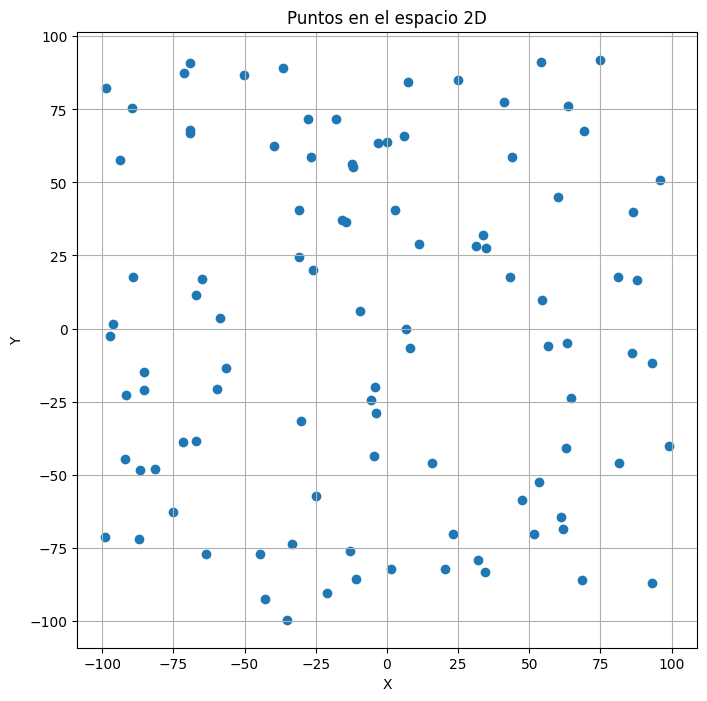

In [3]:
# Defino una semilla
seed = 1234

# Genero los puntos
puntos = create_2d_points_df(100, seed)

# Ploteo los puntos
plot_points(puntos)

# Calculo distancias
distancias = calculate_distance(puntos)

In [5]:
# Definimos el modelo
modelo_mtz = pywraplp.Solver.CreateSolver('SAT')

list_index_puntos = list(puntos.index)

# uso n como n-1 ya que arranco de indice 0 en la lista. Por esto en mtz no resto 1 ni en u_i
n = max(list_index_puntos)

# Definimos variables

x_ij={i:{j: modelo_mtz.IntVar(0,1,'x_'+str(i)+'_'+str(j)) for j in points_sub(list_index_puntos, i)} for i in list_index_puntos}
u_i = {i: modelo_mtz.IntVar(1,n,'u_'+str(i)) for i in points_sub(list_index_puntos, 0)}

# Definimos la función objetivo
obj_expr = sum(x_ij[i][j] * distancias[i][j] for i in list_index_puntos for j in points_sub(list_index_puntos, i))


#Restricciones:

#1
for j in list_index_puntos:
    modelo_mtz.Add(sum(x_ij[i][j] for i in points_sub(list_index_puntos, j)) == 1)

#2
for i in list_index_puntos:
    modelo_mtz.Add(sum(x_ij[i][j] for j in points_sub(list_index_puntos, i)) == 1)

#3
for i in points_sub(list_index_puntos, 0):
    for j in points_sub(points_sub(list_index_puntos, 0), i):
        modelo_mtz.Add(u_i[i] - u_i[j] + 1 <= n * (1- x_ij[i][j]))


# Solver
modelo_mtz.Minimize(obj_expr)

In [6]:
inicio = time.time()
status = modelo_mtz.Solve()
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")

Tiempo de ejecución: 697.2730700969696 segundos


In [7]:
if status == pywraplp.Solver.OPTIMAL:
    print("Costo total:", modelo_mtz.Objective().Value())
else:
    print("No se encontró solución óptima.")

Costo total: 1530.4892402519954


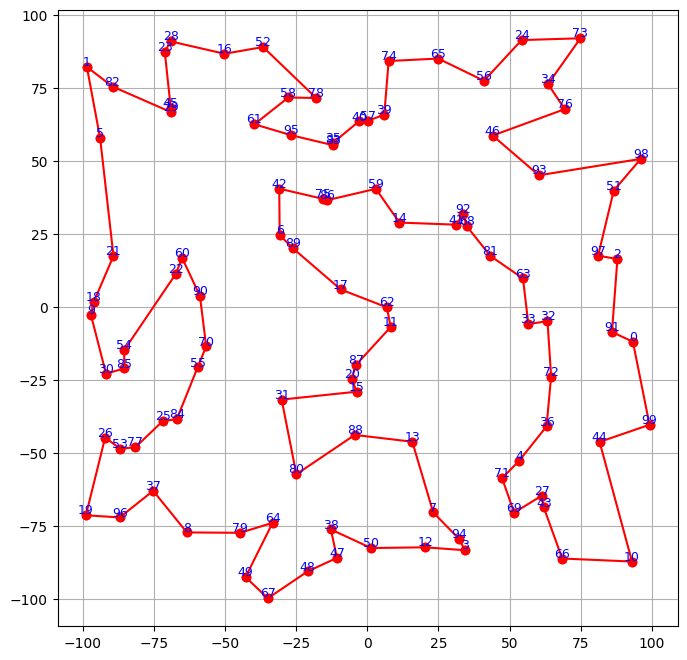

In [8]:
plt.figure(figsize=(8, 8))
plt.grid(True)
for i in list_index_puntos:
    for j in points_sub(list_index_puntos, i):
        if x_ij[i][j].SolutionValue() == 1:
            plt.plot(puntos.iloc[[i,j]]['x'], puntos.iloc[[i,j]]['y'], 'ro-')
            plt.text(puntos.iloc[i]['x'], puntos.iloc[i]['y'] + 0.5, str(i), ha='center', fontsize=9, color='blue')    
plt.show()

Esta ejecución llevó casi 12 minutos, con un costo mínimo encontrado de 1530.4892402519954

Y si usamos un algoritmo genético?

Para comenzar, generamos un subset de cadenas iniciales, donde tomamos como partida el 0 y luego tenemos los demás puntos elegidos de una forma aleatoria.

In [36]:
def secuencia_random(puntos, seed, cantidad=10):
    """
    Genera una secuencia aleatoria de indices de puntos.

    Args:
      puntos: dataframe de pandas con columnas 'x' e 'y'.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      Una lista con una secuencia aleatoria de indices de puntos.
    """
    secuencia = []
    for i in list(range(cantidad)):
      random.seed(seed + i)
      lista_indices = list(puntos.index)
      lista_indices = lista_indices[1:]
      random.shuffle(lista_indices)
      lista_indices = [0] + lista_indices
      secuencia.append(lista_indices)
      
    return secuencia

In [61]:
secs = secuencia_random(puntos, 42, cantidad=30)

In [43]:
def calcular_distancia_total(secuencia, distancias):
    """
    Calcula la distancia total de una secuencia de indices de puntos.

    Args:
      secuencia: lista con una secuencia de indices de puntos.
      distancias: matriz de distancias euclídeas.

    Returns:
      La distancia total de la secuencia.
    """
    distancia_total = 0
    for i in range(len(secuencia) - 1):
        distancia_total += distancias[secuencia[i]][secuencia[i + 1]]
    distancia_total += distancias[secuencia[-1]][secuencia[0]]  # Volver al punto inicial
    return distancia_total

In [62]:
for i in range(len(secs)):
    print(f"Distancia total de la secuencia {i+1}: {calcular_distancia_total(secs[i], distancias)}")

Distancia total de la secuencia 1: 10218.796399795056
Distancia total de la secuencia 2: 10526.596981415856
Distancia total de la secuencia 3: 10569.995765383479
Distancia total de la secuencia 4: 10378.727453419731
Distancia total de la secuencia 5: 10730.408896810302
Distancia total de la secuencia 6: 10947.413080477532
Distancia total de la secuencia 7: 10661.179800205691
Distancia total de la secuencia 8: 11027.207162627643
Distancia total de la secuencia 9: 10842.510434982669
Distancia total de la secuencia 10: 10547.419645117196
Distancia total de la secuencia 11: 10285.326102046161
Distancia total de la secuencia 12: 9940.688702058887
Distancia total de la secuencia 13: 10565.102816584173
Distancia total de la secuencia 14: 10352.09913238319
Distancia total de la secuencia 15: 10470.021346625126
Distancia total de la secuencia 16: 11420.975156738752
Distancia total de la secuencia 17: 10711.155973823054
Distancia total de la secuencia 18: 11331.881442543954
Distancia total de la

In [63]:
def mutar_secuencia(secuencia, seed):
    """ 
    Mutar una secuencia de indices de puntos intercambiando dos puntos aleatoriamente.

    Args:
      secuencia: lista con una secuencia de indices de puntos.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      Una nueva secuencia mutada.
    """
    random.seed(seed)
    nueva_secuencia = secuencia.copy()
    idx1, idx2 = random.sample(range(1, len(secuencia)), 2)  # Evitar el primer punto (índice 0)
    nueva_secuencia[idx1], nueva_secuencia[idx2] = nueva_secuencia[idx2], nueva_secuencia[idx1]
    return nueva_secuencia

In [64]:
def proceso_evolutivo(distancias, poblacion_inicial, generaciones, tasa_mutacion, seed):
    """
    Implementa un proceso evolutivo para optimizar la secuencia de puntos.

    Args:
      distancias: matriz de distancias euclídeas.
      poblacion_inicial: lista de listas con secuencias iniciales de indices de puntos.
      generaciones: número de generaciones a ejecutar.
      tasa_mutacion: probabilidad de mutación para cada secuencia.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      La mejor secuencia encontrada y su distancia total.
    """
    poblacion = poblacion_inicial.copy()
    mejor_secuencia = None
    mejor_distancia = float('inf')

    for gen in range(generaciones):
        nuevas_secuencias = []
        for secuencia in poblacion:
            # if random.random() < tasa_mutacion:
            #     secuencia_mutada = mutar_secuencia(secuencia, seed + gen)
            #     nuevas_secuencias.append(secuencia_mutada)
            # else:
            #     nuevas_secuencias.append(secuencia)
            
            secuencia_mutada = mutar_secuencia(secuencia, seed + gen) #hago que se muten todas las secuencias
            nuevas_secuencias.append(secuencia_mutada)
            

        poblacion = nuevas_secuencias

        for secuencia in poblacion:
            distancia = calcular_distancia_total(secuencia, distancias)
            if distancia < mejor_distancia:
                mejor_distancia = distancia
                mejor_secuencia = secuencia

    return mejor_secuencia, mejor_distancia

In [66]:
inicio = time.time()
mejor_secuencia, mejor_distancia = proceso_evolutivo(distancias, secs, generaciones=100000, tasa_mutacion=1, seed=42)
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")
print("Mejor secuencia encontrada:", mejor_secuencia)
print("Distancia total de la mejor secuencia:", mejor_distancia)

Tiempo de ejecución: 63.504587173461914 segundos
Mejor secuencia encontrada: [0, 33, 51, 8, 38, 30, 26, 43, 5, 70, 96, 82, 95, 36, 27, 55, 94, 77, 31, 84, 12, 44, 15, 29, 79, 67, 6, 21, 50, 39, 24, 57, 45, 1, 65, 58, 35, 76, 99, 69, 32, 88, 3, 54, 25, 89, 7, 75, 13, 81, 63, 60, 14, 4, 46, 66, 64, 19, 17, 83, 34, 2, 61, 49, 10, 18, 37, 90, 74, 78, 42, 68, 16, 52, 40, 23, 73, 56, 92, 86, 59, 20, 71, 93, 41, 53, 9, 85, 91, 72, 22, 28, 62, 47, 11, 48, 80, 87, 98, 97]
Distancia total de la mejor secuencia: 8365.86089350857


In [71]:
def proceso_evolutivo_mejorado(distancias, poblacion_inicial, generaciones, tasa_mutacion, seed):
    """
    Implementa un proceso evolutivo para optimizar la secuencia de puntos.

    Args:
      distancias: matriz de distancias euclídeas.
      poblacion_inicial: lista de listas con secuencias iniciales de indices de puntos.
      generaciones: número de generaciones a ejecutar.
      tasa_mutacion: probabilidad de mutación para cada secuencia.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      La mejor secuencia encontrada y su distancia total.
    """
    poblacion = poblacion_inicial.copy()
    mejor_secuencia = None
    mejor_distancia = float('inf')

    for gen in range(generaciones):
        nuevas_secuencias = []
        for secuencia in poblacion:
            # if random.random() < tasa_mutacion:
            #     secuencia_mutada = mutar_secuencia(secuencia, seed + gen)
            #     nuevas_secuencias.append(secuencia_mutada)
            # else:
            #     nuevas_secuencias.append(secuencia)
            
            secuencia_mutada = mutar_secuencia(secuencia, seed + gen) #hago que se muten todas las secuencias
            distancia_mutada = calcular_distancia_total(secuencia_mutada, distancias)
            distancia_original = calcular_distancia_total(secuencia, distancias)
            if distancia_mutada < distancia_original:
              nuevas_secuencias.append(secuencia_mutada)
            else:
              nuevas_secuencias.append(secuencia)

        poblacion = nuevas_secuencias
        
    # lo muevo al final total siempre llegan las mismas secuencias y para no recalcular tantas veces
    for secuencia in poblacion:
        distancia = calcular_distancia_total(secuencia, distancias)
        if distancia < mejor_distancia:
            mejor_distancia = distancia
            mejor_secuencia = secuencia

    return mejor_secuencia, mejor_distancia

In [72]:
inicio = time.time()
mejor_secuencia, mejor_distancia = proceso_evolutivo_mejorado(distancias, secs, generaciones=100000, tasa_mutacion=1, seed=42)
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")
print("Mejor secuencia encontrada:", mejor_secuencia)
print("Distancia total de la mejor secuencia:", mejor_distancia)

Tiempo de ejecución: 107.35254693031311 segundos
Mejor secuencia encontrada: [0, 91, 2, 97, 92, 41, 68, 94, 3, 12, 67, 49, 55, 70, 90, 22, 84, 25, 37, 8, 96, 19, 26, 85, 54, 9, 30, 53, 77, 18, 21, 5, 1, 82, 60, 20, 15, 88, 38, 48, 47, 50, 7, 69, 43, 27, 4, 36, 44, 72, 32, 33, 63, 51, 98, 81, 13, 64, 79, 80, 31, 86, 75, 95, 61, 29, 45, 23, 28, 16, 52, 58, 78, 35, 83, 40, 57, 39, 65, 74, 42, 6, 89, 17, 87, 11, 62, 14, 59, 46, 56, 24, 73, 34, 76, 93, 71, 66, 10, 99]
Distancia total de la mejor secuencia: 2441.639809163893


En menos de 2 minutos, conseguimos una muy buena primera aproximación